# Define areas of interest

Define 3 to 4 areas of interest: in OMZ (southern Pacific), outside OMZ, near-shore Peru and maybe in OMZ (northern Pacific). Create mask for the areas of interest and a plot to show where they are.<br>
Start by looking at established areas, e.g. Niño 1+2 area as "inside OMZ". It's easier to justify established areas than randomly new-defined areas of choice.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
exec(open('/home/koehne/Documents/scripts/python/martinfr/myromstools.py').read()) # import compute_zlev, compute_dz

In [2]:
# Define variables
depth = 100
thresholds = [60,22,5]
threshold = thresholds[0]
variable = 'O2'
year_vec = range(1979,2017)

In [3]:
# Read grid
gridfile = '/net/kryo/work/koehne/roms/inputs/humpac15/N64ts10tb4hc250_grd_merged_SiO3_PO4_fix/grd/humpac15_grd.nc'
romsGrd = getGrid(gridfile)
# Add necessary attributes
filepath = '/net/kryo/work/koehne/roms/output/humpac15/N64ts10tb4hc250_grd_merged_SiO3_PO4_fix/humpac15_hindcast_1979_2016_6/daily/avg/'
romsGrd.getAttrs(filepath+'humpac15_2006_avg.nc')
# Add lat lon
romsGrd.getLatLon()
# Add grid area
romsGrd.getArea()
# Add angle
romsGrd.getAngle()

grid = xr.open_dataset(gridfile)

In [4]:
#%% Open dataset and save all O2 timeseries
O2_timeseries = np.zeros((len(year_vec)*12,1009,701))
i = 0
for year in year_vec:
    data = xr.open_dataset('/net/kryo/work/koehne/roms/output/humpac15/N64ts10tb4hc250_grd_merged_SiO3_PO4_fix/humpac15_hindcast_1979_2016_6/monthly/avg_zslice/'+str(variable)+'_'+str(depth)+'/z_humpac15_'+str(year)+'_avg_'+variable+'_'+str(depth)+'.nc')
    O2_timeseries[i*12:(i+1)*12,:,:] = data.O2.values[:,:,:]
    data.close()
    i += 1
    data.close()
    
meanO2 = O2_timeseries.mean(axis=0)

Make masks for continents and the areas of interest.

In [5]:
# Mask continents
mask = np.zeros_like(grid.mask_rho) + np.NaN
mask[grid.mask_rho==1] = 1

Regions of interest: <br>
 - In OMZ (South Pacific): 0-10°S, 90-80°W (equals Niño 1+2 index area)
 - In OMZ (North Pacific): 
 - Outside OMZ: 
 - Near-shore Peru:

In [6]:
# this is a small add on to draw a small box in the plot to highlight an area
mask_area = np.zeros_like(grid.lon_rho)
lon_lims = np.logical_and(grid.lon_rho-360.<-102,grid.lon_rho-360.>-112)
lat_lims = np.logical_and(grid.lat_rho<15,grid.lat_rho>5)
mask_area[np.logical_and(lon_lims,lat_lims)] = 1

In [7]:
# Mask regions of interest
# Region 1: inside OMZ SP
mask_regionSP = np.zeros_like(grid.lon_rho)
lon_limsSP = np.logical_and(grid.lon_rho-360.<-80,grid.lon_rho-360.>-90)
lat_limsSP = np.logical_and(grid.lat_rho<0,grid.lat_rho>-10)
mask_regionSP[np.logical_and(lon_limsSP,lat_limsSP)] = 1

# Corrected area over ROMS grid area
area = romsGrd.area.data
mask_areaSP = np.zeros_like(grid.lon_rho) + np.NaN
mask_areaSP[np.logical_and(lon_limsSP,lat_limsSP)] = area[np.logical_and(lon_limsSP,lat_limsSP)]
mask_areaSP_dum = mask_areaSP[np.newaxis,:,:]
mask_areaSP_3D = np.tile(mask_areaSP_dum,(len(year_vec),1,1))

In [8]:
# Region 2: inside OMZ NP
mask_regionNP = np.zeros_like(grid.lon_rho)
lon_limsNP = np.logical_and(grid.lon_rho-360.<-100,grid.lon_rho-360.>-110)
lat_limsNP = np.logical_and(grid.lat_rho<15,grid.lat_rho>5)
mask_regionNP[np.logical_and(lon_limsNP,lat_limsNP)] = 1

area = romsGrd.area.data
mask_areaNP = np.zeros_like(grid.lon_rho) + np.NaN
mask_areaNP[np.logical_and(lon_limsNP,lat_limsNP)] = area[np.logical_and(lon_limsNP,lat_limsNP)]
mask_areaNP_dum = mask_areaNP[np.newaxis,:,:]
mask_areaNP_3D = np.tile(mask_areaNP_dum,(len(year_vec),1,1))

In [9]:
# Region 3: outside OMZ
mask_regionOO = np.zeros_like(grid.lon_rho)
lon_limsOO = np.logical_and(grid.lon_rho-360.<-85,grid.lon_rho-360.>-95)
lat_limsOO = np.logical_and(grid.lat_rho<-15,grid.lat_rho>-25)
mask_regionOO[np.logical_and(lon_limsOO,lat_limsOO)] = 1

area = romsGrd.area.data
mask_areaOO = np.zeros_like(grid.lon_rho) + np.NaN
mask_areaOO[np.logical_and(lon_limsOO,lat_limsOO)] = area[np.logical_and(lon_limsOO,lat_limsOO)]
mask_areaOO_dum = mask_areaOO[np.newaxis,:,:]
mask_areaOO_3D = np.tile(mask_areaOO_dum,(len(year_vec),1,1))

In [10]:
# Region 4: near-shore Peru
mask_areaNS = np.zeros_like(grid.lon_rho)
lon_limsNS = np.logical_and(grid.lon_rho-360.<-80,grid.lon_rho-360.>-90)
lat_limsNS = np.logical_and(grid.lat_rho<0,grid.lat_rho>-10)
mask_areaNS[np.logical_and(lon_limsNS,lat_limsNS)] = 1

In [11]:
# Region 1: inside OMZ SP
area = romsGrd.area.data
mask_areaSP = np.zeros_like(grid.lon_rho) + np.NaN
mask_areaSP[np.logical_and(lon_limsSP,lat_limsSP)] = area[np.logical_and(lon_limsSP,lat_limsSP)]
mask_areaSP_dum = mask_areaSP[np.newaxis,:,:]
mask_areaSP_3D = np.tile(mask_areaSP_dum,(len(year_vec),1,1))

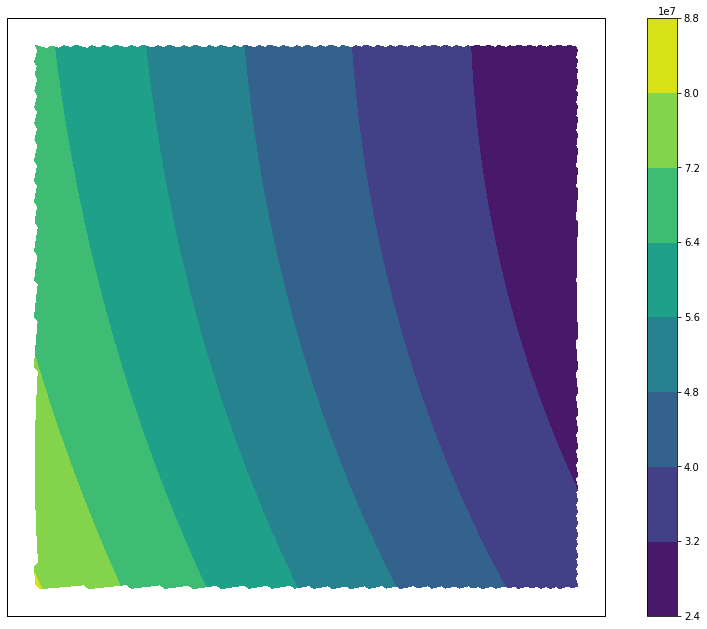

In [12]:
fig = plt.figure(figsize=(15,11))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
c12 = ax.contourf(grid.lon_rho-360.,grid.lat_rho,mask_areaSP,transform=ccrs.PlateCarree())
plt.colorbar(c12)
plt.show()

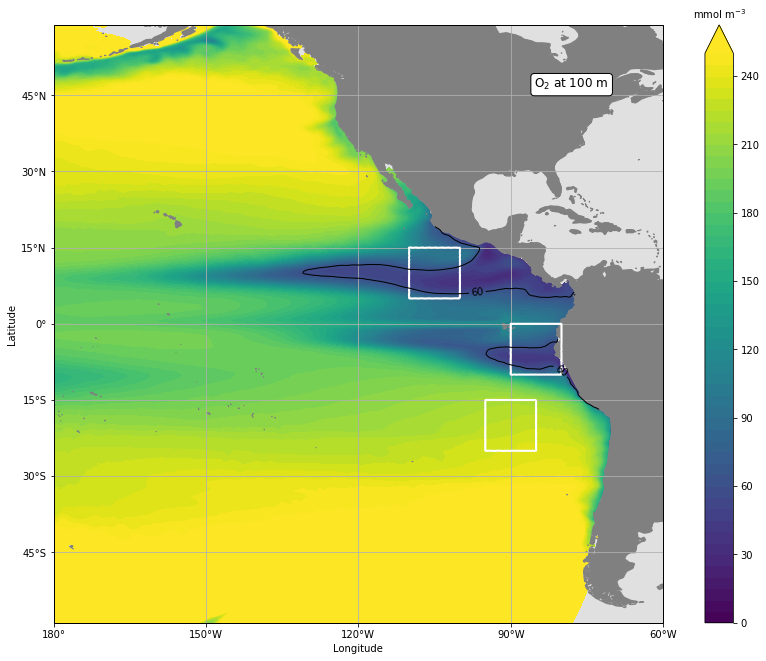

In [13]:
fig = plt.figure(figsize=(15,11))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='#808080'))
ax.imshow(np.tile(np.array([[[224, 224, 224]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -180, 180])
c0 = ax.contourf(grid.lon_rho-360,grid.lat_rho,meanO2*mask,levels=np.linspace(0,250,51), extend='max',transform=ccrs.PlateCarree())
c1 = ax.contour(grid.lon_rho-360.,grid.lat_rho,mask_regionSP,levels=[0.5],colors='w',linewidths=2,transform=ccrs.PlateCarree())
c2 = ax.contour(grid.lon_rho-360.,grid.lat_rho,mask_regionNP,levels=[0.5],colors='w',linewidths=2,transform=ccrs.PlateCarree())
c3 = ax.contour(grid.lon_rho-360.,grid.lat_rho,mask_regionOO,levels=[0.5],colors='w',linewidths=2,transform=ccrs.PlateCarree())
#c4 = ax.contour(grid.lon_rho-360.,grid.lat_rho,mask_regionNS,levels=[0.5],colors='w',linewidths=1,transform=ccrs.PlateCarree())
c00 = ax.contour(grid.lon_rho-360,grid.lat_rho,meanO2*mask,[60],colors='k',linewidths=1,transform=ccrs.PlateCarree())
plt.clabel(c00,fmt='%1d',inline_spacing=1)
ax.text(0.85,0.9, r'O$_2$ at 100 m', transform=ax.transAxes, size=12, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w'))
ax.set_xticks([180, 210, 240, 270, 300], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -45, -30, -15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
ax.set_extent([180-360, 300-360, -40, 40])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(c0)
cb.set_label('mmol m$^{-3}$', labelpad=-40, y=1.03, rotation=0)
plt.show()
fig.savefig('/nas/meilers/Documents/MScThesis/Python/humpac15_hindcast_06_analysis/Helpful_stuff/plots/humpac15_hindcast_06_Helpfull_stuff/areas.png', dpi=300)


In [14]:
NZclim = O2_timeseries.shape[0]

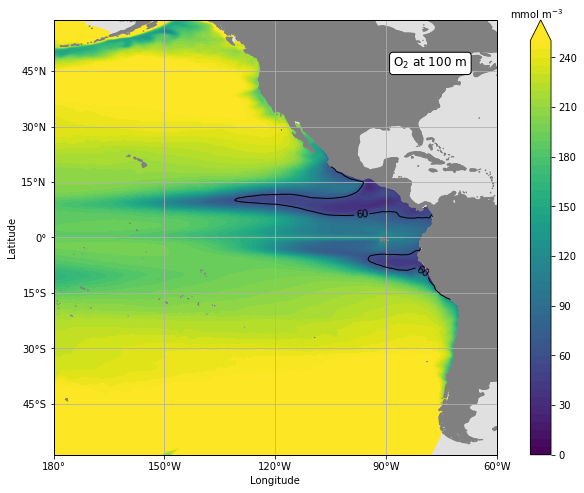

In [15]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='#808080'))
ax.imshow(np.tile(np.array([[[224, 224, 224]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -180, 180])
c0 = ax.contourf(grid.lon_rho-360,grid.lat_rho,meanO2*mask,levels=np.linspace(0,250,51), extend='max',transform=ccrs.PlateCarree())
c00 = ax.contour(grid.lon_rho-360,grid.lat_rho,meanO2*mask,[60],colors='k',linewidths=1,transform=ccrs.PlateCarree())
plt.clabel(c00,fmt='%1d',inline_spacing=1)
ax.text(0.85,0.9, r'O$_2$ at 100 m', transform=ax.transAxes, size=12, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w'))
ax.set_xticks([180, 210, 240, 270, 300], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -45, -30, -15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
ax.set_extent([180-360, 300-360, -40, 40])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cb = plt.colorbar(c0)
cb.set_label('mmol m$^{-3}$', labelpad=-40, y=1.03, rotation=0)
plt.show()
#fig.savefig('/nas/meilers/Documents/MScThesis/Python/humpac15_hindcast_06_analysis/O2ExtremeEventAnalysis/plots/humpac15_hindcast_06_O2ExtremeEventsAnalysis/Blob/plot_avg_1deg_northpacific_blob.png', dpi=300)
